In [99]:
import pymc as pm 
import pandas as pd
import numpy as np
import seaborn as sns
# import theano.tensor as tt
import aesara.tensor as at

In [94]:
df = pd.read_csv('iihs2020.csv')

In [95]:
df.head()

,model,size,type,deaths,class,interval,MV,SV,roll,model years,exposure
0,Mitsubishi Mirage hatchback,1,car4d,72,4door,28-115,52.0,18.0,5.0,2014-17,171842
1,Kia Rio,1,car4d,87,4door,40-134,51.0,38.0,0.0,2014-17,204326
2,Hyundai Accent,1,car4d,116,4door,74-158,85.0,28.0,9.0,2014-17,417171
3,Ford Fiesta,1,car4d,141,4door,94-189,98.0,46.0,13.0,2014-17,357492
4,Volkswagen Golf,2,car4d,0,4door,0-34,0.0,0.0,0.0,2014-17,108084


In [96]:
df[df.model == 'Subaru Outback']

,model,size,type,deaths,class,interval,MV,SV,roll,model years,exposure
80,Subaru Outback,3,wagon,3,NaN,0-6,2.0,1.0,0.0,NaN,769921


In [97]:
# Convert! 
# exposure is "registered vehicle years"
# "deaths" (rates) are per 1M reg. years, to get to per 10B miles multiply by .72 
miles_e6 = df['exposure'].to_numpy() / 1e6


fatalities = (df['deaths']*df['exposure']).to_numpy() / 1e6 /1000

Text(0, 0.5, 'miles_e6')

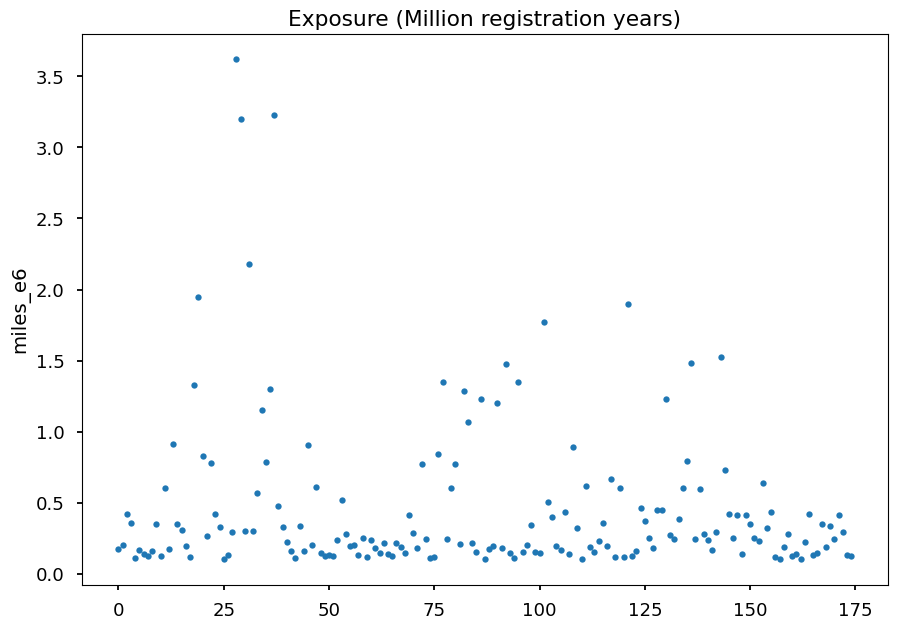

In [98]:
plt.plot(miles_e6, '.')
plt.title("Exposure (Million registration years)")
plt.ylabel("miles_e6")

Text(0, 0.5, 'fatalities')

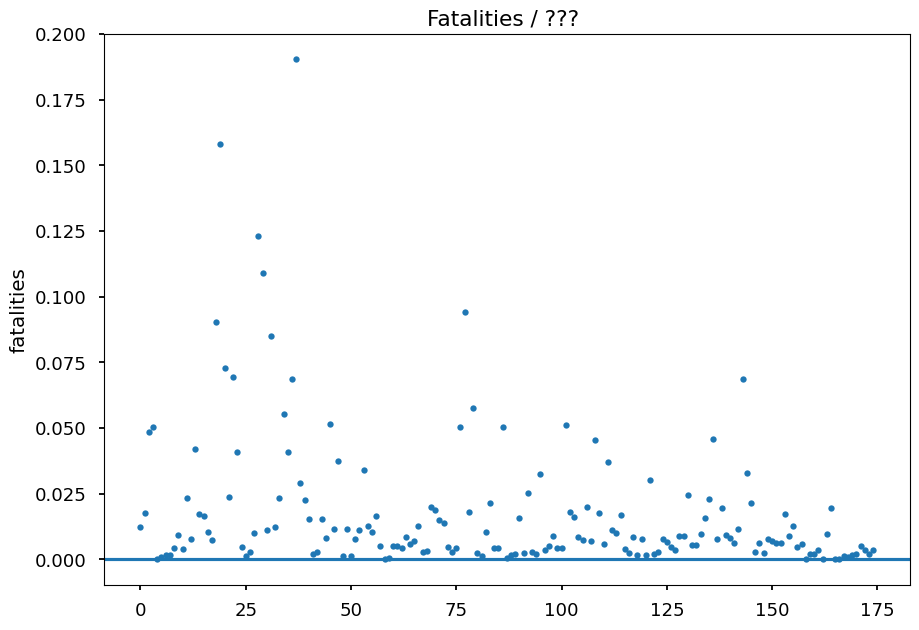

In [74]:
plt.plot(fatalities, '.')
plt.axhline()
plt.title("Fatalities / ??? ")
plt.ylabel("fatalities")

In [100]:
def car_model(miles, fatalities):  # , google_miles=.77, google_fatalities=2/1000
    with pm.Model() as model:
        pooled_rate = pm.Uniform('pooled_rate', lower=0.0, upper=1.0)
        κ_log = pm.Exponential('κ_log', lam=1.5)
        κ = pm.Deterministic('κ', at.exp(κ_log))

        state_rate = pm.Beta('state_rate', 
                             alpha=pooled_rate*κ, 
                             beta=(1.0-pooled_rate)*κ, 
                             shape=len(fatalities))
        observed_fatalities = pm.Poisson('y', mu=state_rate*miles, observed=fatalities)

        # google_rate = pm.Beta('google_rate', 
        #                       alpha=pooled_rate*κ, 
        #                       beta=(1.0-pooled_rate)*κ)
        # observed_google_fatalities = pm.Poisson('y_new', 
        #                                         mu=google_miles*google_rate, 
        #                                         observed=google_fatalities)
    return model

In [101]:
with car_model(miles_e6, fatalities):
    trace = pm.sample(10000)  # , njobs=4

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/urs/miniforge3/envs/pm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pooled_rate, κ_log, state_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


ContextualVersionConflict: ignored

/Users/urs/miniforge3/envs/pm/lib/python3.10/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


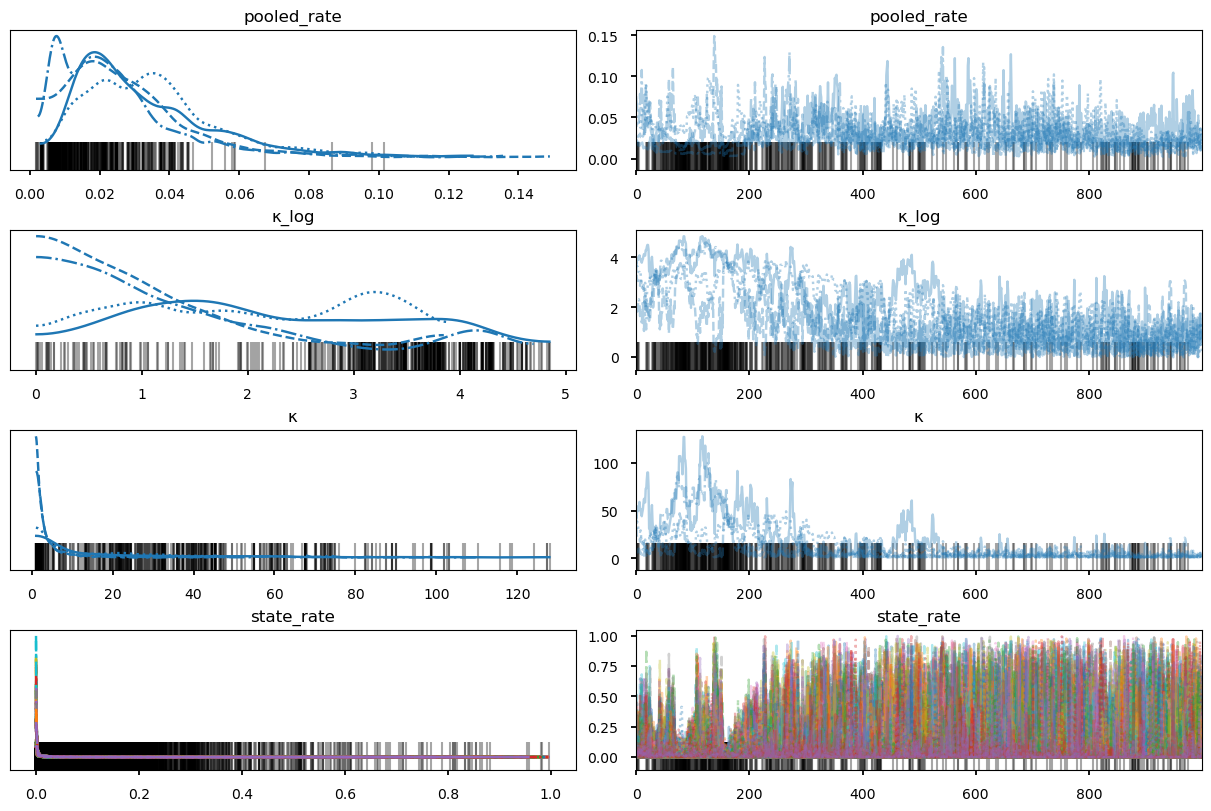

In [103]:
pm.plot_trace(trace);

In [104]:
plt.style.use('seaborn-talk')

/var/folders/nq/b0dv04_s3vq1hly8sc_w45n00000gp/T/ipykernel_44771/1058997633.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')


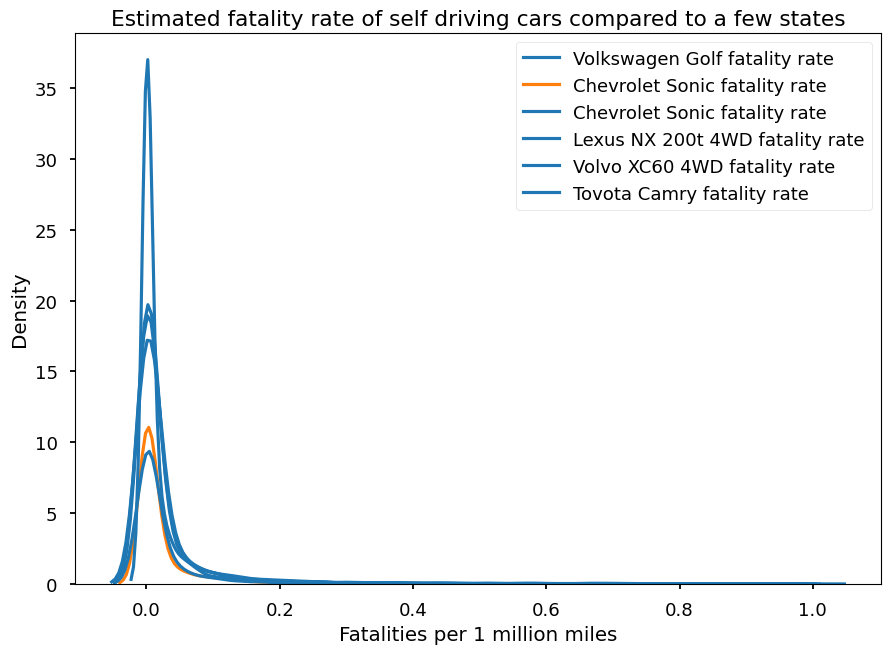

In [105]:
fig, ax = plt.subplots(1, 1)
for state in ('Volkswagen Golf', 'Chevrolet Sonic', 'Lexus NX 200t 4WD', 'Volvo XC60 4WD', 'Tovota Camry'):
    sns.kdeplot(trace['state_rate'][:, df.model == state], label='{} fatality rate'.format(state))
# sns.kdeplot(trace['google_rate'], label='Google fatality rate')
# fig.set_size_inches(18.5, 10.5)
# ax.set_xlim(xmin=0)
# ax.set_ylim(ymin=-10)
ax.set_title('Estimated fatality rate of self driving cars compared to a few states')
ax.set_xlabel('Fatalities per 1 million miles')

ax.legend();